In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# 定义数据处理的流程
transform = transforms.Compose(
    [
        # 转化图片为张量
        transforms.ToTensor(),
        # 正则化图片
        transforms.Normalize(
            # 三个通道的均值
            (0.5, 0.5, 0.5),
            # 三个通道的方差
            (0.5, 0.5, 0.5)
        )
    ]
)

# 下载数据
trainset = torchvision.datasets.CIFAR10(
    # 存放位置
    root='./data',
    # 下载训练数据
    train=True,
    # 是否下载
    download=True, 
    # 下载完成后，处理流程
    transform=transform
)

# 定义数据加载器
trainloader = torch.utils.data.DataLoader(
    # 加载的数据集
    trainset,
    # 每个批次的个数
    batch_size=4,
    # 重新洗牌
    shuffle=True,
    # 加载线程个数
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=4,
    shuffle=False, 
    num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


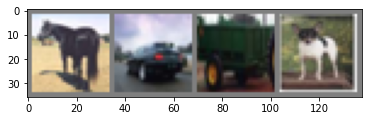

horse   car truck   dog


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 展示图片
def imshow(img):
    # 去正则化
    img = img / 2 + 0.5
    # tensor 转 np
    npimg = img.numpy()
    # 显示图片
    plt.imshow(
        # 矩阵转置
        np.transpose(
            # 被转置的矩阵
            npimg,
            # （x,y,z）转为（y,z,x）
            (1, 2, 0)
        )
    )
    # 显示图片
    plt.show()


# 加载的图片的迭代器
dataiter = iter(trainloader)
# 获取第一个批次
images, labels = dataiter.next()

# 展示图片
imshow(
    # 整合第一个批次的图片为一个
    torchvision.utils.make_grid(images)
)
# 展示图片的标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

> nn.Conv2d(ci,co,(k1,k2)) 数学公式

\begin{align}
O_{j} &= B_{j} + \sum _{i=1}^{ci} W_{j,i} \cdot I_{i} \quad (j=1 \cdots co) \\
ci &： 输入图片的通道数量 \\
co &： 输出数据的通道数量 \\
k1、k2 &： 卷积核的大小 \\
Oj &： 卷积后输出数据 \\
Bj &： 卷积偏移 \\
Wji &： 卷积核权重 \\
Ii &： 输入图片的各个通道数据
\end{align}

> nn.MaxPool2d(k1,k2)) 数学公式

\begin{align}
O_{j, h, w} &= \max_{m=0, \ldots, k1-1} \max_{n=0, \ldots, k2-1} I_{j, h + m, w + n} \\
j &： 输入图片的通道数量 \\
k1、k2 &： 卷积核的大小 \\
h、w &： 每次卷积的起始位置
\end{align}

> nn.Linear(c1,c2) 数学公式

\begin{align}
O_{j} &= B_{j} +  W_{j} \cdot I_{j} \quad (j=1 \cdots co) \\
co &： 输入图片的通道数量 \\
c1 &： 输入图片的矩阵行数 \\
c2 &： 输出图片的矩阵行数
\end{align}

> F.relu 数学公式

\begin{align}
O_{i,j}  &= I_{i,j} \quad (i=1 \cdots w,j=1 \cdots h) \\
i &： 输入图片的矩阵列数 \\
j &： 输入图片的矩阵行数
\end{align}


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层         
        self.conv1 = nn.Conv2d(3, 6, 5)
        # 池化层        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # 张量视图，共享底层内存
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

> nn.CrossEntropyLoss

\begin{align}
H (Y,Y^{'}) &= - {Y^{'}}\log(softmax(Y)) \\
     softmax(Y) &= \log\left(\frac{\exp(Y)}{\sum_j \exp(y_j)}\right) \\
     Y^{'} &: 分类向量，只有一个为1,标识类别 \\
     Y &: 原始数据，未归一化
\end{align}


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
# 对整个数据集运行两次
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取数据,data 格式 [inputs, labels]
        inputs, labels = data

        # 梯度归零
        optimizer.zero_grad()

        # 处理原始数据
        outputs = net(inputs)
        # 计算损失         
        loss = criterion(outputs, labels)
        # 求导
        loss.backward()
        # 迭代
        optimizer.step()

        # 输出信息
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.183
[1,  4000] loss: 1.810
[1,  6000] loss: 1.636


KeyboardInterrupt: 

In [ ]:
PATH = './data/cifar_net.pth'
# 保存模型数据
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 展示测试数据
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = Net()

# 加载模型
net.load_state_dict(torch.load(PATH))

In [ ]:
# 预测图片
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
# 计算在测试数据上的准确率
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))